In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
all_present = mep_present and eeg_present
print(all_present)

True


In [4]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set'
]

# View the EEG

In [5]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

In [6]:
def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

In [4]:
# Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

In [8]:
# Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

In [9]:
# Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

In [10]:
# Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

In [11]:
# Calculate EEG area.
def calculate_eeg_area(epoch_df):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    area = np.trapz(np.abs(y.values), epoch_df['time'].values)
    return area

In [12]:
# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

In [13]:
def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

In [14]:
def band_max(freq, psd, start=0, end=4):
    channel_indices = [np.where(freq >= start and freq <= end)[1][0] for searchval in channel_names]
    freq = freq[start:end]
    psd = psd[start:end]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

In [15]:
def band_max(freq, psd, start=0, end=4):
    indices = np.where((freq >= start) & (freq <= end))
    freq = freq[indices]
    psd = psd[indices]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

In [16]:
def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','z','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

In [17]:
def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

In [18]:
def extract_features(eeg_path):
    mep_path = get_mep_path(eeg_path)
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_trials(epochs)
    mep_frames = open_mep_as_df(mep_path)
    epoch_features = []
    if len(epochs) != len(mep_frames):
        # print('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path + ' and ' + mep_path)
        raise Exception('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path + ' and ' + mep_path)
        return
    for i in range(len(epochs)):
        epoch = epochs[i]
        mep = mep_frames[i]
        segments = eeg_path.split('/')
        d = {'sub': segments[2], 'exp': segments[3], 'run': segments[5], 'epoch': i}

        freq, psd = calculate_eeg_frequency(epoch.drop('time', axis=1).values.mean(axis=1))
        d['all_all_max_power_freq'], d['all_all_max_power'] = band_max(freq, psd, 4, 40)
        d['all_delta_max_power_freq'], d['all_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['all_theta_max_power_freq'], d['all_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['all_alpha_max_power_freq'], d['all_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['all_beta_max_power_freq'], d['all_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['all_gamma_max_power_freq'], d['all_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch, 'ltm1').drop('time', axis=1).values.mean(axis=1))
        d['ltm1_all_max_power_freq'], d['ltm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['ltm1_delta_max_power_freq'], d['ltm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['ltm1_theta_max_power_freq'], d['ltm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['ltm1_alpha_max_power_freq'], d['ltm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['ltm1_beta_max_power_freq'], d['ltm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['ltm1_gamma_max_power_freq'], d['ltm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch, 'rtm1').drop('time', axis=1).values.mean(axis=1))
        d['rtm1_all_max_power_freq'], d['rtm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['rtm1_delta_max_power_freq'], d['rtm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['rtm1_theta_max_power_freq'], d['rtm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['rtm1_alpha_max_power_freq'], d['rtm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['rtm1_beta_max_power_freq'], d['rtm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['rtm1_gamma_max_power_freq'], d['rtm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        d['area_under_eeg'] = calculate_eeg_area(epoch)
        d['rtm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch, 'rtm1'))
        d['ltm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch, 'ltm1'))
        d['all_max_amplitude'] = calculate_eeg_max_amplitude(epoch.drop('time', axis=1))
        d['rtm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'rtm1'))
        d['ltm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch, 'ltm1'))

        d['mep_size'] = calculate_mep_size(mep)
        epoch_features.append(d)
    return epoch_features

In [19]:
features = []
for eeg_path in tqdm_notebook(eegs):
    features = features + extract_features(eeg_path)

pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.fdt'...
Scaling components to RMS microvolt


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 8192 is greater than input length  = 1024, using nperseg = 1024
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.fdt'...
Scaling components to RMS microvolt
pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.fdt'...
Scaling components to RMS microvolt
pop_loadset(): loading file data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.fdt'...
pop_loadset(): loading file data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.fdt'...
pop_loadset(): loading file data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.fdt'..

In [20]:
df = pd.DataFrame(features)
df.head()

,all_all_max_power,all_all_max_power_freq,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,all_gamma_max_power,all_gamma_max_power_freq,...,rtm1_beta_max_power_freq,rtm1_delta_max_power,rtm1_delta_max_power_freq,rtm1_gamma_max_power,rtm1_gamma_max_power_freq,rtm1_max_amplitude,rtm1_theta_max_power,rtm1_theta_max_power_freq,run,sub
0,3.302811e-16,12.0,3.302811e-16,12.0,2.467210e-16,28.0,1.113595e-16,4.0,9.772056e-16,474.0,...,18.0,1.689008,2.0,0.341022,32.0,4.859485,1.064474,4.0,SP 110RMT r1,sub03
1,3.492257e-16,18.0,1.957960e-16,16.0,3.492257e-16,18.0,8.303895e-17,2.0,1.418834e-15,126.0,...,32.0,0.441164,4.0,1.557364,34.0,3.863017,0.788006,8.0,SP 110RMT r1,sub03
2,7.988662e-16,4.0,3.865362e-16,12.0,4.727435e-16,20.0,9.401751e-16,2.0,2.173197e-15,402.0,...,30.0,1.014214,2.0,2.147177,38.0,12.325154,0.320580,8.0,SP 110RMT r1,sub03
3,8.951575e-16,14.0,8.951575e-16,14.0,8.458415e-16,16.0,2.501884e-16,4.0,1.558474e-15,94.0,...,20.0,0.508378,2.0,0.687888,40.0,1.277029,0.447221,8.0,SP 110RMT r1,sub03
4,1.500408e-15,14.0,1.500408e-15,14.0,1.127975e-15,16.0,7.168404e-17,4.0,1.411026e-15,84.0,...,16.0,4.893132,2.0,1.219589,34.0,5.525887,5.053958,6.0,SP 110RMT r1,sub03


In [21]:
print(df.shape)
print(df.columns)

(1400, 47)
Index(['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg', 'epoch', 'exp',
       'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
       'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
       'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
       'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
       'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
       'ltm1_max_amplitude', 'ltm1_theta_max_power',
       'ltm1_theta_max_power_freq', 'mep_size', 'rtm1_all_max_power',
       'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
       'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
       'rtm1_beta_max_power', 'rtm1

Text(0, 0.5, 'MEP Size')

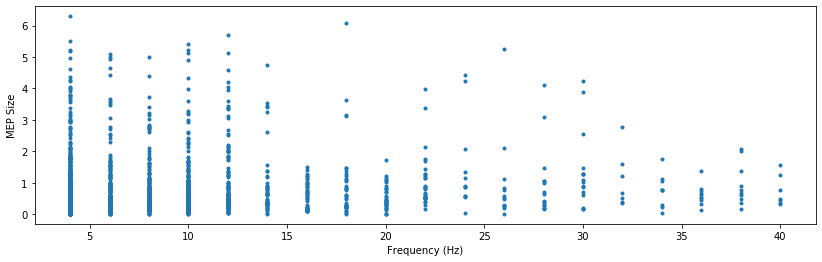

In [22]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

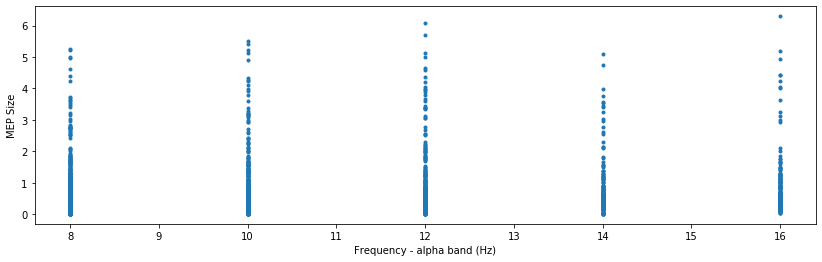

In [23]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

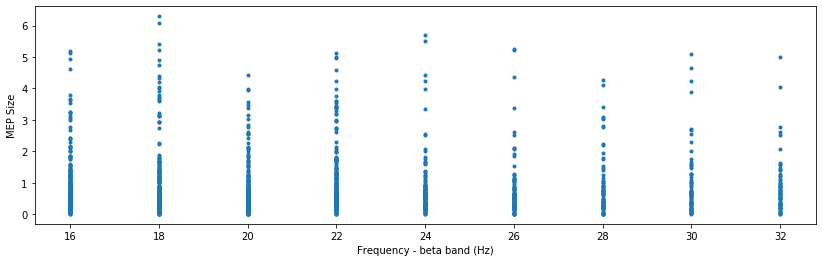

In [24]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

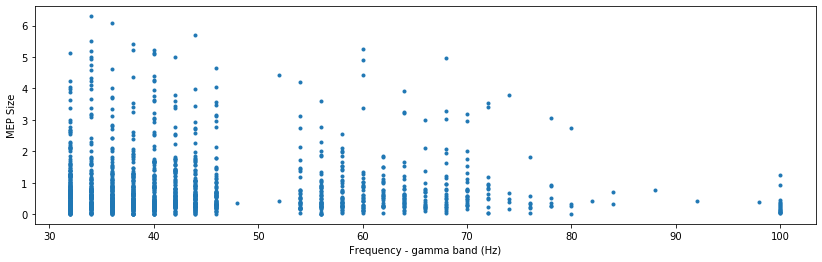

In [25]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

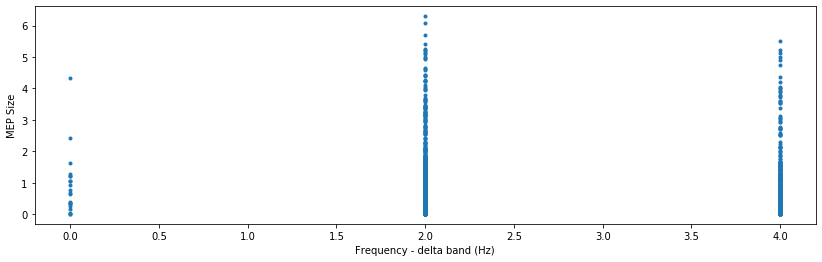

In [26]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

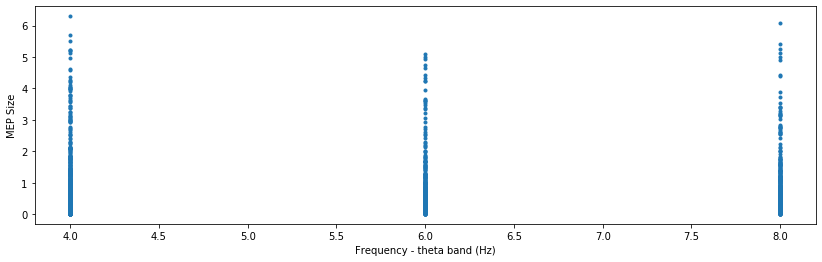

In [27]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Size')

In [28]:
df2 = df.groupby(['sub', 'exp', 'run']).mean()
df2.head()

all_all_max_power  all_all_max_power_freq  \
sub   exp   run                                                       
sub03 exp01 SP 110RMT r1       6.640821e-16                   19.32   
            SP 110RMT r2       4.466377e-15                   20.92   
            SP 110RMT r3       6.051590e-15                   23.96   
      exp02 SP 110RMT r1       1.151576e-13                   23.00   
            SP 110RMT r2       2.069195e-14                   21.88   

                          all_alpha_max_power  all_alpha_max_power_freq  \
sub   exp   run                                                           
sub03 exp01 SP 110RMT r1         4.469653e-16                     12.24   
            SP 110RMT r2         2.858178e-15                     11.64   
            SP 110RMT r3         3.568232e-15                     12.04   
      exp02 SP 110RMT r1         6.864915e-14                     12.12   
            SP 110RMT r2         1.075677e-14                     11.88   

                          all_beta_max_power  all_beta_max_power_freq  \
sub   exp   run                                                         
sub03 exp01 SP 110RMT r1        4.696769e-16                    23.40   
            SP 110RMT r2        3.310342e-15                    23.96   
            SP 110RMT r3        5.163827e-15                    24.08   
      exp02 SP 110RMT r1        9.090041e-14                    24.00   
            SP 110RMT r2        1.712459e-14                    24.40   

                          all_delta_max_power  all_delta_max_power_freq  \
sub   exp   run                                                           
sub03 exp01 SP 110RMT r1         2.411776e-16                      2.84   
            SP 110RMT r2         1.727658e-15                      2.68   
            SP 110RMT r3         2.279777e-15                      3.08   
      exp02 SP 110RMT r1         4.949722e-14                      2.68   
            SP 110RMT r2         1.093247e-14                      2.76   

                          all_gamma_max_power  all_gamma_max_power_freq  ...  \
sub   exp   run                                                          ...   
sub03 exp01 SP 110RMT r1         1.139970e-15                    284.92  ...   
            SP 110RMT r2         6.910752e-15                    265.96  ...   
            SP 110RMT r3         1.112198e-14                    243.04  ...   
      exp02 SP 110RMT r1         2.380817e-13                    275.92  ...   
            SP 110RMT r2         3.399026e-14                    241.96  ...   

                          rtm1_area_under_eeg  rtm1_beta_max_power  \
sub   exp   run                                                      
sub03 exp01 SP 110RMT r1          2581.975423             1.386683   
            SP 110RMT r2         12804.848506            18.505805   
            SP 110RMT r3         16328.854372            23.290055   
      exp02 SP 110RMT r1         21301.606027            36.371786   
            SP 110RMT r2          2406.021186             1.142789   

                          rtm1_beta_max_power_freq  rtm1_delta_max_power  \
sub   exp   run                                                            
sub03 exp01 SP 110RMT r1                     22.20              2.384860   
            SP 110RMT r2                     23.88            105.824573   
            SP 110RMT r3                     23.12            182.917339   
      exp02 SP 110RMT r1                     21.52            393.019052   
            SP 110RMT r2                     23.00              4.849091   

                          rtm1_delta_max_power_freq  rtm1_gamma_max_power  \
sub   exp   run                                                             
sub03 exp01 SP 110RMT r1                       2.60              0.972593   
            SP 110RMT r2                       2.48             17.951296   
            SP 110RMT r3                       2.32             20.7372

In [29]:
df2.shape

(28, 44)

Text(0, 0.5, 'MEP Size')

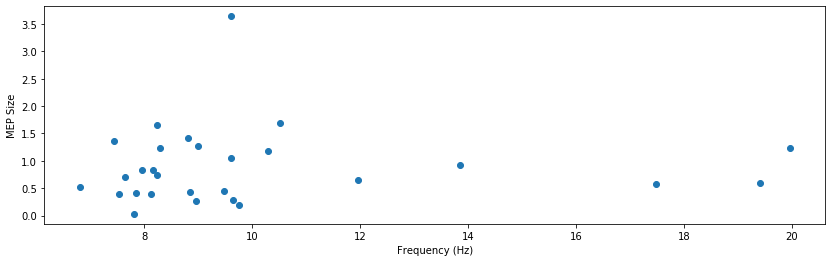

In [30]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_all_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

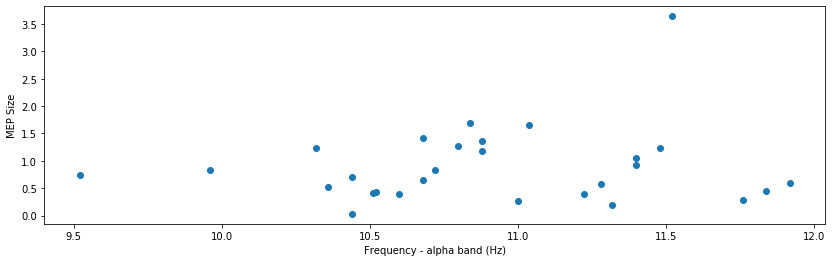

In [31]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_alpha_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

# Frequency bins

In [32]:
bins = [0, 4, 8, 16, 32, 100]
df3_mean = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).mean()
df3_max = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).max()
df3_min = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).min()
df3_mean['mep_size_mean'] = df3_mean['mep_size']
df3_mean['mep_size_max'] = df3_max['mep_size']
df3_mean['mep_size_min'] = df3_min['mep_size']
df3_mean['rtm1_all_max_power_freq'] = df3_mean.index

In [33]:
df3_mean[['rtm1_all_max_power_freq', 'mep_size_mean', 'mep_size_max', 'mep_size_min']]

,rtm1_all_max_power_freq,mep_size_mean,mep_size_max,mep_size_min
rtm1_all_max_power_freq,,,,
"(0, 4]","(0, 4]",0.847437,6.295166,0.008697
"(4, 8]","(4, 8]",0.901801,5.427094,0.014343
"(8, 16]","(8, 16]",0.958486,5.267792,0.010834
"(16, 32]","(16, 32]",0.855730,5.698090,0.015869
"(32, 100]","(32, 100]",0.823664,3.158875,0.240326


Text(0.5, 1.0, 'Left M1 Electrode Frequency Bins vs MEP Size')

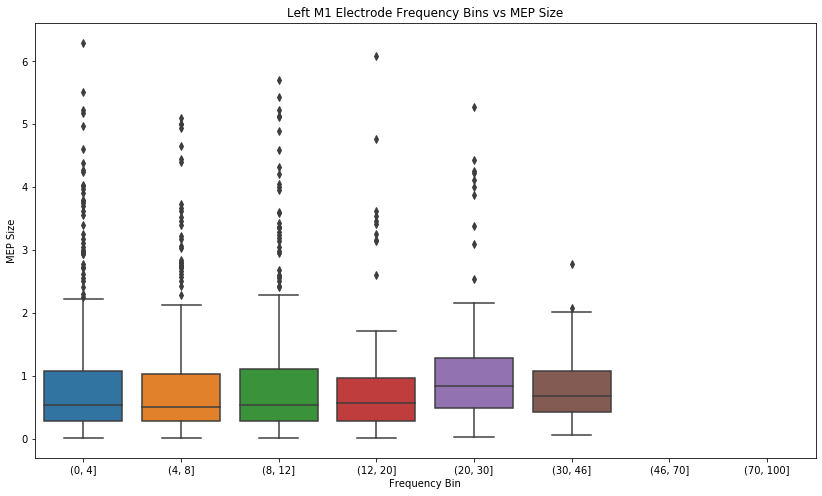

In [34]:
df4 = df
bins = [0, 4, 8, 12, 20, 30, 46, 70, 100]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Left M1 Electrode Frequency Bins vs MEP Size')

In [35]:
df.shape

(1400, 48)

Text(0.5, 1.0, 'Right M1 Electrode Frequency Bins vs MEP Size')

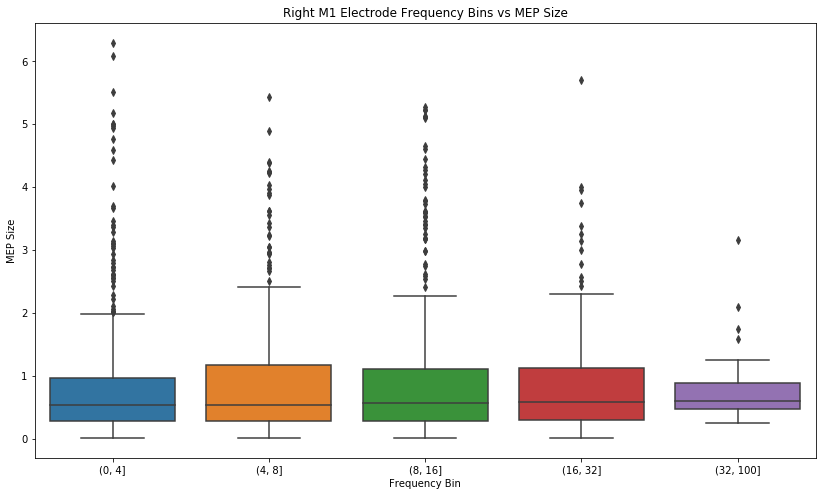

In [36]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['rtm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Right M1 Electrode Frequency Bins vs MEP Size')

Text(0.5, 1.0, 'All Electrodes Frequency Bins vs MEP Size')

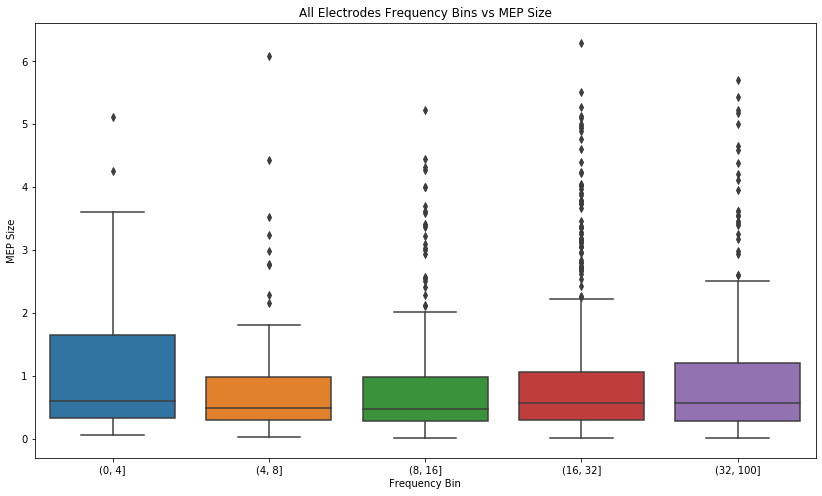

In [37]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['all_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('All Electrodes Frequency Bins vs MEP Size')

Text(0, 0.5, 'MEP Size')

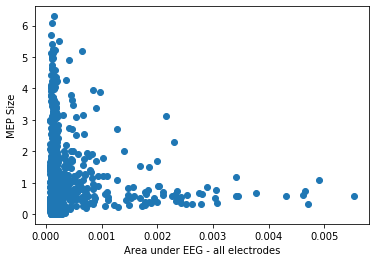

In [38]:
plt.plot(df4['area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - all electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

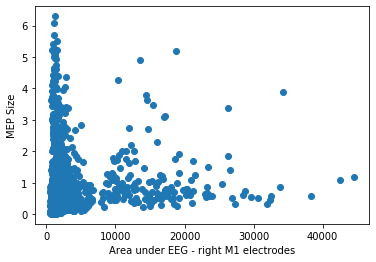

In [39]:
plt.plot(df4['rtm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - right M1 electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

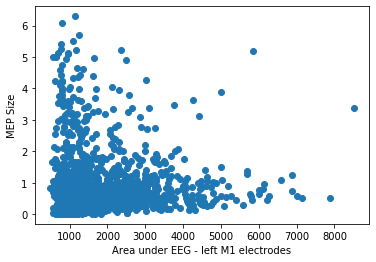

In [40]:
plt.plot(df4['ltm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - left M1 electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

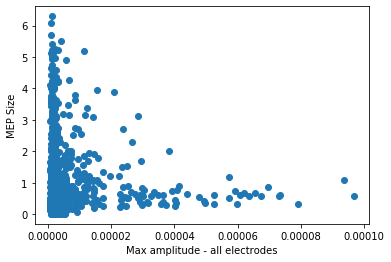

In [41]:
plt.plot(df4['all_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - all electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

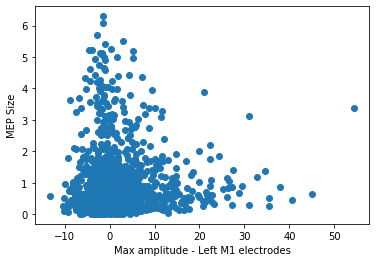

In [42]:
plt.plot(df4['ltm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Left M1 electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

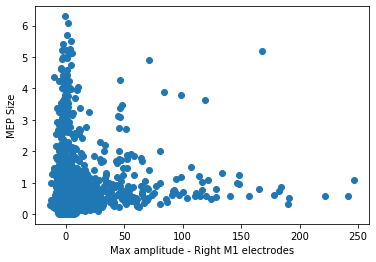

In [43]:
plt.plot(df4['rtm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Right M1 electrodes')
plt.ylabel('MEP Size')

# Linear Regression

In [44]:
df.dtypes

all_all_max_power             float64
all_all_max_power_freq        float64
all_alpha_max_power           float64
all_alpha_max_power_freq      float64
all_beta_max_power            float64
all_beta_max_power_freq       float64
all_delta_max_power           float64
all_delta_max_power_freq      float64
all_gamma_max_power           float64
all_gamma_max_power_freq      float64
all_max_amplitude             float64
all_theta_max_power           float64
all_theta_max_power_freq      float64
area_under_eeg                float64
epoch                           int64
exp                            object
ltm1_all_max_power            float64
ltm1_all_max_power_freq       float64
ltm1_alpha_max_power          float64
ltm1_alpha_max_power_freq     float64
ltm1_area_under_eeg           float64
ltm1_beta_max_power           float64
ltm1_beta_max_power_freq      float64
ltm1_delta_max_power          float64
ltm1_delta_max_power_freq     float64
ltm1_gamma_max_power          float64
ltm1_gamma_m

In [45]:
x = df[['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg',
       'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
       'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
       'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
       'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
       'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
       'ltm1_max_amplitude', 'ltm1_theta_max_power',
       'ltm1_theta_max_power_freq', 'rtm1_all_max_power',
       'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
       'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
       'rtm1_beta_max_power', 'rtm1_beta_max_power_freq',
       'rtm1_delta_max_power', 'rtm1_delta_max_power_freq',
       'rtm1_gamma_max_power', 'rtm1_gamma_max_power_freq',
       'rtm1_max_amplitude', 'rtm1_theta_max_power',
       'rtm1_theta_max_power_freq']]
y = df['mep_size']

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

In [47]:
model = LinearRegression().fit(x_train, y_train)

In [48]:
y_predicted = model.predict(x_test)
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print(r2)

-0.06507137765621951


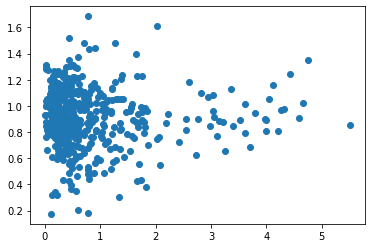

In [49]:
plt.plot(y_test, y_predicted, 'o')

# Random Forest

In [51]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

In [52]:
rf = RandomForestRegressor(n_estimators = 5000, random_state = 42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, y_pred))

R2 score: -0.09503056743107718


# TPOT

In [53]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_01_pipeline_accuracy_100.py')

Generation 1 - Current best internal CV score: -1.011778625893613
Generation 2 - Current best internal CV score: -1.0081078249832096
Generation 3 - Current best internal CV score: -1.0081078249832096
Generation 4 - Current best internal CV score: -1.0081078249832096
Generation 5 - Current best internal CV score: -1.0067834802774174
Generation 6 - Current best internal CV score: -1.0067834802774174
Generation 7 - Current best internal CV score: -1.0057427499440392
Generation 8 - Current best internal CV score: -1.0015941383911016
Generation 9 - Current best internal CV score: -1.0015941383911016
Generation 10 - Current best internal CV score: -1.0001680075938584
Generation 11 - Current best internal CV score: -0.9992622395161763
Generation 12 - Current best internal CV score: -0.9992622395161763
Generation 13 - Current best internal CV score: -0.9949600140059591
Generation 14 - Current best internal CV score: -0.9949600140059591
Generation 15 - Current best internal CV score: -0.9928983

In [54]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_02_pipeline_r2_100.py')

Generation 1 - Current best internal CV score: 0.019710201829758668
Generation 2 - Current best internal CV score: 0.019710201829758668
Generation 3 - Current best internal CV score: 0.027531456564835865
Generation 4 - Current best internal CV score: 0.027531456564835865
Generation 5 - Current best internal CV score: 0.027531456564835865
Generation 6 - Current best internal CV score: 0.027531456564835865
Generation 7 - Current best internal CV score: 0.027531456564835865
Generation 8 - Current best internal CV score: 0.03800793845805195
Generation 9 - Current best internal CV score: 0.03800793845805195
Generation 10 - Current best internal CV score: 0.03800793845805195
Generation 11 - Current best internal CV score: 0.04148200883919269
Generation 12 - Current best internal CV score: 0.04148200883919269
Generation 13 - Current best internal CV score: 0.043868703397881716
Generation 14 - Current best internal CV score: 0.043868703397881716
Generation 15 - Current best internal CV score: 

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_03_pipeline_r2_400.py')

Generation 1 - Current best internal CV score: 0.018539345820622378
Generation 2 - Current best internal CV score: 0.02027048271065457
Generation 3 - Current best internal CV score: 0.023365418773583314
Generation 4 - Current best internal CV score: 0.023365418773583314
Generation 5 - Current best internal CV score: 0.026462860038529313
Generation 6 - Current best internal CV score: 0.03319132850639073
Generation 7 - Current best internal CV score: 0.03319132850639073
Generation 8 - Current best internal CV score: 0.043125155542123615
Generation 9 - Current best internal CV score: 0.043125155542123615
Generation 10 - Current best internal CV score: 0.043125155542123615
Generation 11 - Current best internal CV score: 0.043125155542123615
Generation 12 - Current best internal CV score: 0.043125155542123615
Generation 13 - Current best internal CV score: 0.043125155542123615
Generation 14 - Current best internal CV score: 0.043125155542123615
Generation 15 - Current best internal CV score

Generation 122 - Current best internal CV score: 0.07294594011017645
Generation 123 - Current best internal CV score: 0.07294594011017645
Generation 124 - Current best internal CV score: 0.07294594011017645
Generation 125 - Current best internal CV score: 0.07294594011017645
Generation 126 - Current best internal CV score: 0.07294594011017645
Generation 127 - Current best internal CV score: 0.07294594011017645
Generation 128 - Current best internal CV score: 0.07294594011017645
Generation 129 - Current best internal CV score: 0.07294594011017645
Generation 130 - Current best internal CV score: 0.07294594011017645
Generation 131 - Current best internal CV score: 0.07294594011017645
Generation 132 - Current best internal CV score: 0.07294594011017645
Generation 133 - Current best internal CV score: 0.07294594011017645
Generation 134 - Current best internal CV score: 0.07294594011017645
Generation 135 - Current best internal CV score: 0.07294594011017645
Generation 136 - Current best inte

Generation 241 - Current best internal CV score: 0.08284215647342685
Generation 242 - Current best internal CV score: 0.08284215647342685
Generation 243 - Current best internal CV score: 0.08284215647342685
Generation 244 - Current best internal CV score: 0.08284215647342685
Generation 245 - Current best internal CV score: 0.08284215647342685
Generation 246 - Current best internal CV score: 0.08284215647342685
Generation 247 - Current best internal CV score: 0.08284215647342685
Generation 248 - Current best internal CV score: 0.08284215647342685
Generation 249 - Current best internal CV score: 0.08284215647342685
Generation 250 - Current best internal CV score: 0.08284215647342685
Generation 251 - Current best internal CV score: 0.08284215647342685
Generation 252 - Current best internal CV score: 0.08284215647342685
Generation 253 - Current best internal CV score: 0.08284215647342685
Generation 254 - Current best internal CV score: 0.08284215647342685
Generation 255 - Current best inte

In [ ]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_03_pipeline_accuracy_400.py')

# Test pipeline

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

In [ ]:
exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_regression, percentile=7),
    StackingEstimator(estimator=KNeighborsRegressor(n_neighbors=29, p=1, weights="distance")),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.25, min_samples_leaf=20, min_samples_split=15, n_estimators=100)),
    SelectPercentile(score_func=f_regression, percentile=48),
    RandomForestRegressor(bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=14, min_samples_split=16, n_estimators=100)
)

exported_pipeline.fit(x_train, y_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, exported_pipeline.predict(x_train)))
print("Test R2 score:", sklearn.metrics.r2_score(y_test, exported_pipeline.predict(x_test)))